# POS tagging

Part-of-speech (POS) tagging is a fundamental step in the process of natural language processing (NLP) that involves assigning grammatical categories to individual words in a text. These categories typically include nouns, verbs, adjectives, adverbs, prepositions, conjunctions, and more. By determining the role that each word plays in a sentence, POS tagging helps facilitate a deeper understanding of the sentence’s structure and meaning. This task is essential for numerous applications, such as speech recognition, machine translation, and information retrieval, making it a cornerstone of computational linguistics.

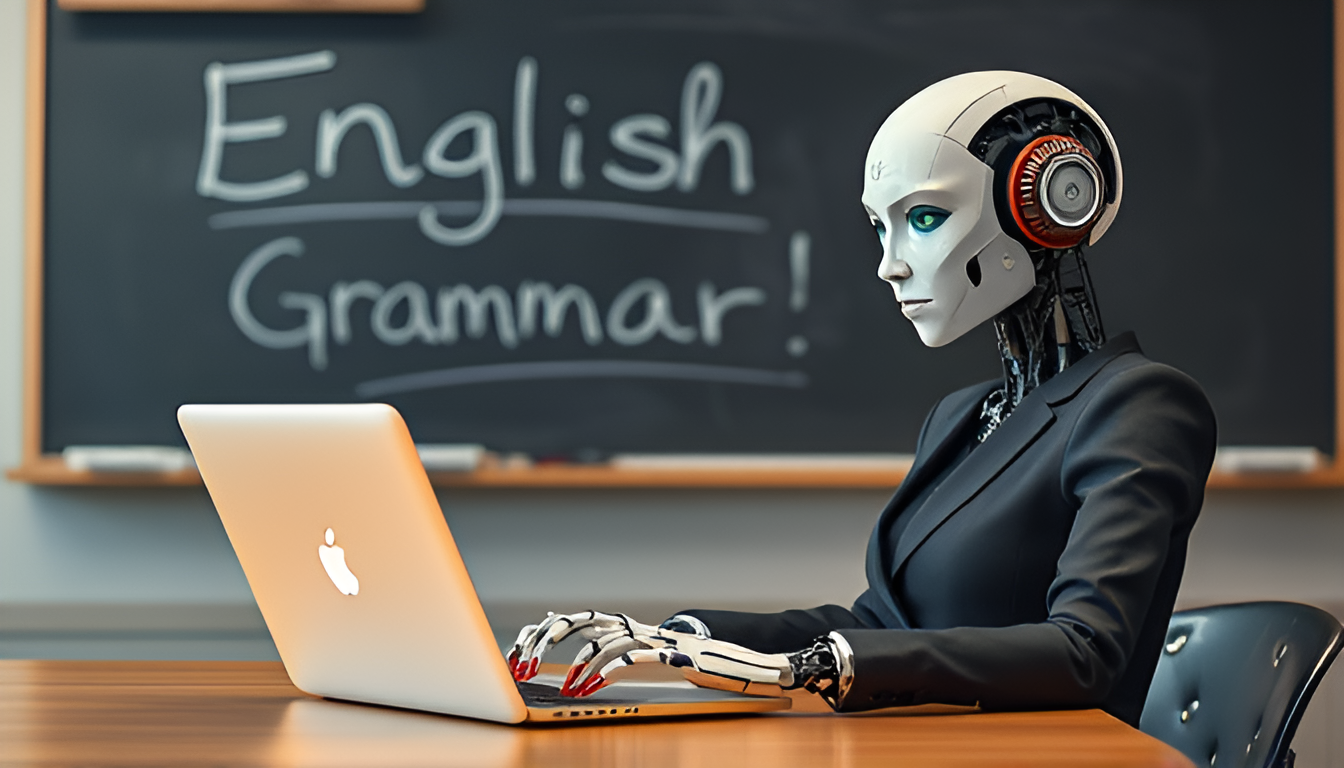

### Import Packages
In this initial step, we import essential Python packages that are critical for implementing part-of-speech (POS) tagging.

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset
Once the required packages are imported, the next step involves loading the dataset that we will use for training and testing our POS tagging models. This dataset typically contains sentences annotated with their corresponding part-of-speech tags, which allows us to train our models effectively. Proper loading and formatting of the dataset are crucial to ensure seamless data processing in subsequent steps.

In [2]:
train_set = pd.read_pickle('Data/train_set.pickle')
test_set = pd.read_pickle('Data/test_set.pickle')
val_set = pd.read_pickle('Data/val_set.pickle')

In [3]:
tokens_train_set = pd.DataFrame(pd.Series(train_set['tokens']))
tokens_val_set = pd.DataFrame(pd.Series(val_set['tokens']))
tokens_test_set = pd.DataFrame(pd.Series(test_set['tokens']))

postags_train_set = pd.DataFrame(pd.Series(train_set['pos_tags']) , columns = ['y_true'])
postags_val_set = pd.DataFrame(pd.Series(val_set['pos_tags']) , columns = ['y_true'])

### preprocess
Preprocessing is a vital step where we clean and prepare the dataset for model training.

In [4]:
def Lower_pp(tokens_set) :
    
    def Lower(row) :
        
        pp = []
        for j in row[0] :          
            pp.append(j.lower())
            
        return pp
        
    pp_tokens_set = []
    
    for i in range(len(tokens_set)) :
        r = list(Lower(tokens_set.iloc[i]))
        pp_tokens_set.append(r)

    return pd.DataFrame(pd.Series(pp_tokens_set))

In [5]:
def words_count_dict(tokens) :
    
    words_count = {}
    for i in tokens :
        
        for j in i :
            
            if j in words_count :
                words_count[j] += 1
            else :
                words_count[j] = 1
                
    return words_count

In [6]:
word_count = words_count_dict(Lower_pp(tokens_train_set)[0])

In [7]:
pp_tokens_train_set = Lower_pp(tokens_train_set)
pp_tokens_val_set = Lower_pp(tokens_val_set)
pp_tokens_test_set = Lower_pp(tokens_test_set)

##  Creating Two Different Probabilistic Models:
In this step, we develop two distinct probabilistic models for POS tagging. Each model is trained on the preprocessed dataset using different configurations or algorithms, allowing us to explore various methodologies in handling the POS tagging task. By creating two models, we can compare their performance and gain insights into their strengths and weaknesses.

### creating first model

In [8]:
def create_tagged_words(tokens , postags):
    
    tagged_words = []
    
    for i in range(len(tokens[0])) :
        
        row =[]
        
        for j in range(len(tokens[0].iloc[i])) :
            row.append((tokens[0].iloc[i][j] , postags['y_true'].iloc[i][j]))
        tagged_words.append(row)
        
    return tagged_words

In [9]:
train_tagged_words = create_tagged_words(pp_tokens_train_set , postags_train_set)
val_tagged_words = create_tagged_words(pp_tokens_val_set , postags_val_set)

In [10]:
word_tag_count = {}

for i in train_tagged_words :
    
    for j in i :
        
        if j in word_tag_count :
            word_tag_count[j] += 1
        else :
            word_tag_count[j] = 1

In [11]:
tags_count = {}

for i in postags_train_set['y_true'] :
    
    for j in i :
        
        if j in tags_count :
            tags_count[j] += 1
        else :
            tags_count[j] = 1

In [12]:
tag_tag_count = {}

for i in postags_train_set['y_true'] :
    
    for j in range(len(i) - 1) :
        
        if (i[j] , i[j + 1]) in tag_tag_count :
            tag_tag_count[(i[j], i[j + 1])] += 1
        else :
            tag_tag_count[(i[j], i[j + 1])] = 1

In [13]:
tag_word_tag_count = {}

for i in range(len(train_tagged_words)) :
    
    for j in range(len(train_tagged_words[i]) - 1) :
        
        now = train_tagged_words[i][j]
        nex = train_tagged_words[i][j + 1]
        
        if (now, nex[1]) in tag_word_tag_count :
            tag_word_tag_count[(now , nex[1])] += 1
        else :
            tag_word_tag_count[(now , nex[1])] = 1

In [14]:
tags = list(tags_count.keys())
words = list(word_count.keys())

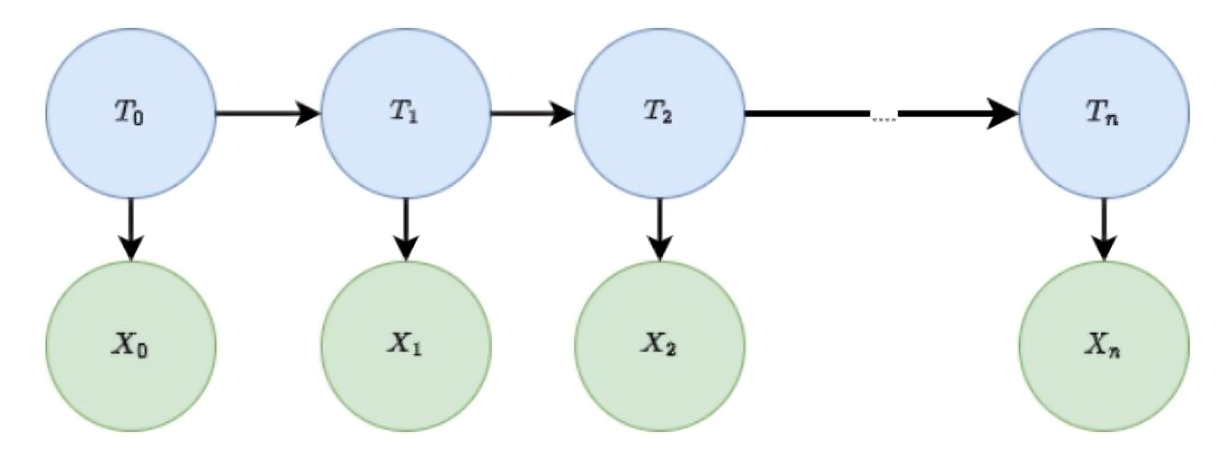

In [15]:
def first_model(new_words , tags , word_tag_count , tags_count , tag_tag_count):
    
    all_tags = []
    num_words = len(new_words)

    for i in range(num_words) :
        max_probability = 0
        best_tag = None

        for tag in tags :
            if i == 0 :
                state_probability = word_tag_count.get((new_words[i] , tag) , 0.001) / tags_count.get(tag , 1)
            else :
                tag_tag_prob = tag_tag_count.get((all_tags[-1] , tag) , 0.001) / tags_count.get(all_tags[-1] , 1)
                
                word_tag_prob = word_tag_count.get((new_words[i] , tag) , 0.001) / tags_count.get(tag , 1)
                
                state_probability = tag_tag_prob * word_tag_prob

            if state_probability >= max_probability :
                max_probability = state_probability
                best_tag = tag

        if best_tag :
            all_tags.append(best_tag)
        else :
            all_tags.append(22)

    return all_tags


In [16]:
def predict_postags(tokens, tags, model ):
    
    t = []
    match model :
        case 1 :
            for new_words in tokens :
                sent_tag = first_model(new_words , tags , word_tag_count , tags_count , tag_tag_count)
                if len(sent_tag) != len(new_words):
                    print('WARNING')
                t.append(sent_tag)
        case 2 :
            for new_words in tokens :
                sent_tag = second_model(new_words , tags , word_tag_count , tags_count , tag_word_tag_count)
                if len(sent_tag) != len(new_words) :
                    print('WARNING')
                t.append(sent_tag)
                
    return t

### predict tags using first model

In [17]:
postags_train_set['y_pred_first_model'] = pd.Series(predict_postags(pp_tokens_train_set[0] ,
                                                                    tags ,
                                                                    1))

postags_val_set['y_pred_first_model'] = pd.Series(predict_postags(pp_tokens_val_set[0] ,
                                                                  tags ,
                                                                  1))

### write predicted tags on file

In [18]:
test_data_1 = {'tokens' : list(pp_tokens_test_set[0]) ,
               'pos_tags' : list(postags_train_set['y_pred_first_model'])}

with open('first_pred.pickle', 'wb') as handle :
    pickle.dump(test_data_1 ,
                handle , 
                protocol = pickle.HIGHEST_PROTOCOL)

### creating second model

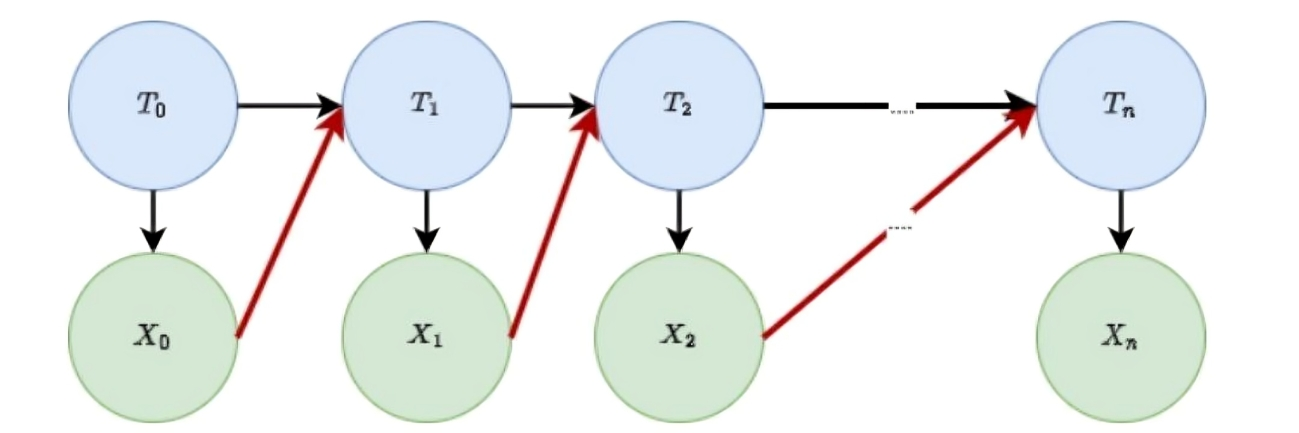

In [19]:
def second_model(new_words , tags , word_tag_count , tags_count , tag_word_tag_count) :
    
    all_tags = []
    initial_probs = {tag : word_tag_count.get((new_words[0] , tag), 0)
                          / tags_count.get(tag , 1) for tag in tags  
                    }

    best_first_tag = max(initial_probs , key = initial_probs.get)
    all_tags.append(best_first_tag)

    for i in range(1 , len(new_words)) :
        max_probability = 0
        best_tag = None

        for current_tag in tags :
            prev_tag = all_tags[-1]

            tag_word_tag_prob = tag_word_tag_count.get(((new_words[i - 1] , prev_tag) , current_tag) , 0.01) / word_tag_count.get((new_words[i - 1] , prev_tag) , 1)
            
            word_tag_prob = word_tag_count.get((new_words[i] , current_tag), 0.01) / tags_count.get(current_tag , 1)

            state_probability = tag_word_tag_prob * word_tag_prob

            if state_probability > max_probability :
                max_probability = state_probability
                best_tag = current_tag

        if best_tag != None :
            all_tags.append(best_tag)
        else : 
            all_tags.append(22)

    return all_tags


### predict tags using second model

In [20]:
postags_train_set['y_pred_second_model'] = pd.Series(predict_postags(pp_tokens_train_set[0] ,
                                                                     tags ,
                                                                     2))

postags_val_set['y_pred_second_model'] = pd.Series(predict_postags(pp_tokens_val_set[0] ,
                                                                   tags ,
                                                                   2))

### write predicted tags on file

In [21]:
test_data_2 = {'tokens' : list(pp_tokens_test_set[0]) ,
               'pos_tags' : list(postags_train_set['y_pred_second_model'])}

with open('second_pred.pickle' , 'wb') as handle :
    pickle.dump(test_data_2 ,
                handle ,
                protocol = pickle.HIGHEST_PROTOCOL)

### Calculating F1 Score:
The final step involves evaluating the performance of our probabilistic models by calculating the F1 score, a measure that balances precision and recall. The F1 score ranges from 0 to 1, where higher values indicate better model performance in accurately predicting POS tags. By assessing the F1 scores of both models, we can ascertain which model is more effective for our specific dataset and application, facilitating informed decisions on model selection and potential improvements.

In [22]:
def f1(postags_train_set , pred_col) :
    
    ac_true = []
    ac_pred = []
    for i in range(len(postags_train_set)) :
        ac_true.extend(postags_train_set['y_true'][i])
        ac_pred.extend(postags_train_set[pred_col][i])
        
    return metrics.f1_score(ac_true , ac_pred , labels = tags, average = 'micro')

In [23]:
print("first model metrics:")

print("f1 train set: " ,
      f1(postags_train_set ,
      'y_pred_first_model'))

print("f1 val set: " ,
      f1(postags_val_set , 
      'y_pred_first_model'))

first model metrics:
f1 train set:  0.9111070329484176
f1 val set:  0.84015456448237


In [24]:
print("second model metrics:")

print("f1 train set: " ,
      f1(postags_train_set ,
      'y_pred_second_model'))

print("f1 val set: " ,
      f1(postags_val_set ,
      'y_pred_second_model'))

second model metrics:
f1 train set:  0.9427284790649086
f1 val set:  0.818290130413782
